In [1]:
import collections
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
)
from rna_learn.load import load_mrna_model, load_dataset
from rna_learn.model import conv1d_classification_model
from rna_learn.vae import variational_autoencoder, compile_vae

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
alphabet_primary = ['A', 'T', 'G', 'C']
alphabet = ['.', '(', ')']
classes = ['psychrophilic', 'mesophilic', 'thermophilic']

In [5]:
therun_id = 'run_mpfr1'
output_folder = os.path.join(os.getcwd(), f'saved_models_2d/{run_id}/')
model_path = os.path.join(output_folder, f'model.h5')
hyperparameters_path = os.path.join(output_folder, f'metadata.json')
test_set_path = os.path.join(os.getcwd(), 'data/dataset_test.csv')

In [6]:
with open(hyperparameters_path) as f:
    hyperparameters = json.load(f)
    
hyperparameters

{'run_id': 'run_mpfr1',
 'alphabet': ['.', '(', ')'],
 'classes': ['psychrophilic', 'mesophilic', 'thermophilic'],
 'n_epochs': 9,
 'n_conv_1': 2,
 'n_filters_1': 100,
 'kernel_size_1': 10,
 'n_conv_2': 0,
 'n_filters_2': 0,
 'kernel_size_2': 0,
 'l2_reg': 0.0001,
 'dropout': 0.5,
 'val_loss': 1.099292516708374,
 'val_accuracy': 0.3609789311885834}

In [7]:
model = load_model(model_path)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, None, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         3100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 100)         100100    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 103,503
Trainable params: 103,503
Non-trainable params: 0
_______________________________________________________

In [8]:
dataset_df = load_dataset(test_set_path, alphabet_primary)
dataset_df.head()

,specie_name,seqid,gene_name,start_inclusive,end_exclusive,length,strand,temperature,temperature_range,sequence,gc_content,secondary_structure,paired_nucleotides
0,Micropolyspora internatus,NC_013159.1,rnpB,742238,742645,407,+,45.0,thermophilic,CGAGTTGGCAGGGCGGCCGCGGCCGAGGGCATCGTCTCGACGTCTT...,0.685504,((((((((((((((..((.(((((((((((.(((...))).)))))...,0.707617
1,Listonella anguillarum,NC_015633.1,recA,2753532,2754579,1047,-,20.0,psychrophilic,ATGGACGAAAATAAGCAGAAGGCGCTAGCCGCAGCACTGGGTCAAA...,0.442216,....................(((....)))(((((..(((((((((...,0.617001
2,Comamonas badia,NZ_AXVM01000006.1,rpsR,29593,29878,285,-,28.0,mesophilic,TTGACCATGTTCAGGAAATTCAACAAGAATGGCAAGAACGGCAAGC...,0.568421,(((.((..((((..(..((((.....))))..)..)))))))))((...,0.610526
3,Acetobacter orientalis,NZ_BAMX01000009.1,tsaD,11584,12799,1215,-,30.0,mesophilic,ATGGCGGTCAGCAGCCAGTTTTCAGGCTTACCCGGCACCCCTCACA...,0.596708,.(((.((((...((((........)))).....(((.............,0.627160
4,Alicyclobacillus kakegawensis,NZ_BCRP01000001.1,tsaD,64880,65918,1038,-,50.0,thermophilic,TTGCTCCTGTTGGGCATTGAGACGAGTTGCGACGAGACCGCCGCGG...,0.680154,......((((.(((((.((...((....((((((.(((((.(((((...,0.697495


In [9]:
sequences = dataset_df['secondary_structure'].values
temperature_classes = dataset_df['temperature_range'].values

x_test = sequence_embedding(sequences, alphabet)
y_test = one_hot_encode_classes(temperature_classes, classes)

In [10]:
%%time
model.evaluate(x_test, y_test, verbose=0)

CPU times: user 1min 13s, sys: 984 ms, total: 1min 14s
Wall time: 11.2 s


[1.0979865629608567, 0.3737838]

In [11]:
%%time
y_pred = model(x_test)

labels = [np.argmax(el) for el in y_test]
predictions = [np.argmax(el) for el in y_pred]

CPU times: user 1min 34s, sys: 42.2 s, total: 2min 16s
Wall time: 29.7 s


In [12]:
def plot_confusion_matrix(labels, predictions, classes, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
        
    conf = tf.math.confusion_matrix(labels, predictions).numpy()
    conf_sum = np.sum(conf, axis=1)
    conf_p = conf / conf_sum
    
    df_cm = pd.DataFrame(
        conf_p, 
        index=[f'{c.title()}' for i, c in enumerate(classes)],
        columns=[f'{c.title()}' for i, c in enumerate(classes)],
    )
    ax = sns.heatmap(df_cm, cmap="Greys", annot=True, fmt='.0%', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_xlabel('\nPredictions');
    ax.set_ylabel('Labels');
    ax.set_title('Confusion Matrix')

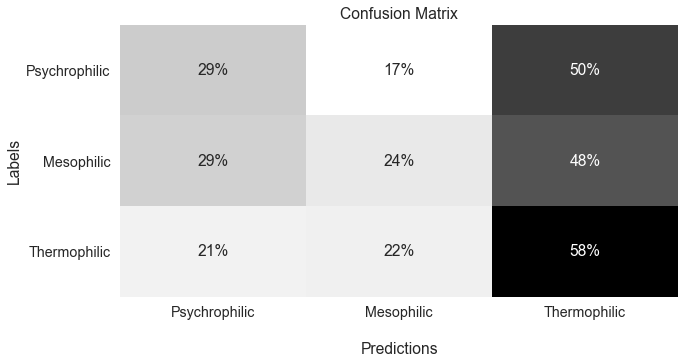

In [13]:
plot_confusion_matrix(labels, predictions, classes)